# Finetuned YOLO Model Results & Analysis

## Setup / Imports

In [2]:
import os
from pathlib import Path
from datetime import datetime
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ultralytics import YOLO

## Define Paths & Values

In [34]:
# ====  SET UP PATHS ====
# Get current working directory
current_dir = os.getcwd()

# Go up one level to the parent directory
parent_dir = os.path.dirname(current_dir)

# Source folder for images
source_folder_img = Path(parent_dir) / "images"

# Destination folder save file outputs 
destination_folder_results = os.path.join(parent_dir, r"results")
os.makedirs(destination_folder_results, exist_ok=True)

# Destination folder wave detected images
destination_folder_det_img = os.path.join(parent_dir, r"results\detected_img")
os.makedirs(destination_folder_det_img, exist_ok=True)

# Destination folder for wave statistic
destination_folder_wave = os.path.join(parent_dir, r"results\wave_stat")
os.makedirs(destination_folder_wave, exist_ok=True)

In [35]:
# Paths for deeplearning models

# Source folder finetuned models
source_folder_deepL = Path(parent_dir) / "img_labeling"

# Paths to finetuned models
yolo8v_N_1000_50  = os.path.join(source_folder_deepL, r"02_waves_yolov8n-1000_50e.pt")
yolo8v_N_1000_150 = os.path.join(source_folder_deepL, r"02_waves_yolov8n-1000_150e.pt")
yolo8v_S_1000_150 = os.path.join(source_folder_deepL, r"03_waves_yolov8s-1000_150e.pt")
yolo8v_S_5000_150 = os.path.join(source_folder_deepL, r"04_waves_yolov8s-5000_150e.pt")

# Detection with YOLO Model

Code version first crop and than only detect the waves in the detected area. 

In [36]:
# USER-DEFINED FILTER RANGE OF SELECTED IMAGES
# ------------------------------------------------------------
START = "2025-10-23 02:00"
END   = "2025-10-23 23:50"

start_dt = datetime.strptime(START, "%Y-%m-%d %H:%M")
end_dt   = datetime.strptime(END,   "%Y-%m-%d %H:%M")


In [37]:
# FUNCTION TO EXTRACT TIMESTAMP FROM NEW FILENAME FORMAT
# expected format: img_YYYY_MM_DD_HH_MM_SS.png
# ------------------------------------------------------------
def extract_timestamp_from_filename(filename: str):
    stem = Path(filename).stem  # remove extension, e.g. img_2022_05_01_12_00_00
    try:
        # remove prefix "img_"
        ts_str = stem.replace("img_", "")
        return datetime.strptime(ts_str, "%Y_%m_%d_%H_%M_%S")
    except ValueError:
        return None  # skip files not matching format

# ------------------------------------------------------------
# FILTER IMAGES
# ------------------------------------------------------------
image_paths = []

for file in sorted(source_folder_img.glob("*.png")):
    ts = extract_timestamp_from_filename(file.name)
    if ts is None:
        continue

    if start_dt <= ts <= end_dt:
        image_paths.append(file)

# ------------------------------------------------------------
# RESULT
# ------------------------------------------------------------
print(f"Selected {len(image_paths)} images between {START} and {END}:")
for p in image_paths[:10]:
    print(p)

Selected 95 images between 2025-10-23 02:00 and 2025-10-23 23:50:
C:\Users\A\Documents\XX_GitHub_Repo\data-waves\images\img_2025_10_23_02_00_00.png
C:\Users\A\Documents\XX_GitHub_Repo\data-waves\images\img_2025_10_23_02_20_00.png
C:\Users\A\Documents\XX_GitHub_Repo\data-waves\images\img_2025_10_23_02_40_00.png
C:\Users\A\Documents\XX_GitHub_Repo\data-waves\images\img_2025_10_23_03_00_00.png
C:\Users\A\Documents\XX_GitHub_Repo\data-waves\images\img_2025_10_23_03_20_00.png
C:\Users\A\Documents\XX_GitHub_Repo\data-waves\images\img_2025_10_23_03_40_00.png
C:\Users\A\Documents\XX_GitHub_Repo\data-waves\images\img_2025_10_23_04_00_00.png
C:\Users\A\Documents\XX_GitHub_Repo\data-waves\images\img_2025_10_23_04_20_00.png
C:\Users\A\Documents\XX_GitHub_Repo\data-waves\images\img_2025_10_23_04_40_00.png
C:\Users\A\Documents\XX_GitHub_Repo\data-waves\images\img_2025_10_23_05_00_00.png


In [38]:
# CONFIGURATION
# ---------------------------------------------------------

# Full-image ROI (pixels)
x_min, x_max = 3837, 4767
y_min, y_max = 1555, 2035
crop_box = (x_min, y_min, x_max + 1, y_max + 1)  # (left, top, right, bottom)

# From ppm experiment calculations we derive this linear regression which yealds below coefficients: ppm(y) = 0.05071 * y + -65.01
a_ppm = 0.05071
b_ppm = -65.01


In [39]:
# LINEAR PPM MODEL CONFIG
# ---------------------------------------------------------

# ---- Linear ppm model from your SUP-board calibration ----
# Assume `a` and `b` are defined in another cell as regression slope & intercept.

def _init_ppm_coeffs():
    """Safely initialize a_ppm and b_ppm from regression a, b."""
    global a_ppm, b_ppm

    # If they already exist and look like floats, don't touch them
    if "a_ppm" in globals() and "b_ppm" in globals():
        if isinstance(a_ppm, (int, float)) and isinstance(b_ppm, (int, float)):
            return

    # Otherwise, take from a, b and force to float
    a_ppm_local = float(a)
    b_ppm_local = float(b)
    a_ppm = a_ppm_local
    b_ppm = b_ppm_local


# Initialize ppm coefficients safely
_init_ppm_coeffs()

def ppm_y(y_full):
    """Pixels-per-meter at full-image vertical coordinate y."""
    return a_ppm * y_full + b_ppm


In [40]:
# ---------------------------------------------------------
# 2. YOLO WAVE-DETECTION CONFIG
# ---------------------------------------------------------

#YOLO_MODEL_PATH = r"03_waves_yolov8s-1000_150e.pt"
#YOLO_MODEL_PATH = r"02_waves_yolov8n-1000_150e.pt"
#YOLO_MODEL_PATH = r"02_waves_yolov8n-1000_50e.pt"
YOLO_MODEL_PATH = r"04_waves_yolov8s-5000_150e.pt"

device = "cuda"      # or "cpu"
wave_class_id = 0    # adjust if your model has multiple classes

yolo_conf = 0.005
yolo_iou = 0.9
yolo_imgsz = (512, 2048)
max_det=10000

model = YOLO(YOLO_MODEL_PATH)

In [41]:
# 3. MAIN LOOP: crop → YOLO on crop → height in meters
# ---------------------------------------------------------

all_wave_rows = []
detections_for_plot = {}  # fname -> list of (x1, y1, x2, y2) in CROP coordinates
cropped_cache = {}        # fname -> cropped PIL image (for plotting later)

for path in image_paths:
    fname = os.path.basename(path)

    try:
        full_img = Image.open(path).convert("RGB")
    except Exception as e:
        print(f"⚠️ Could not open {path}: {e}")
        continue

    # 3.1 crop the ROI first
    cropped = full_img.crop(crop_box)  # coordinates relative to full image
    cropped_cache[fname] = cropped
    detections_for_plot[fname] = []

    # Convert cropped to numpy array for YOLO
    cropped_np = np.array(cropped)

    # 3.2 run YOLO on the cropped image
    try:
        results = model(cropped_np, device=device, conf=yolo_conf,
                        iou=yolo_iou, imgsz=yolo_imgsz,max_det=max_det)
    except Exception as e:
        print(f"⚠️ YOLO inference failed for {path}: {e}")
        continue

    if len(results) == 0:
        continue

    r = results[0]
    boxes = r.boxes
    if boxes is None or len(boxes) == 0:
        continue

    wave_id = 0

    # IMPORTANT: don't reuse `b` here, use `box`
    for box in boxes:
        cls = int(box.cls)
        if cls != wave_class_id:
            continue

        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)  # crop coords
        if x2 <= x1 or y2 <= y1:
            continue

        wave_id += 1
        height_px = y2 - y1

        # vertical midpoint in CROP coordinates
        y_mid_local = 0.5 * (y1 + y2)
        # convert to full-image y (add crop offset)
        y_mid_full = y_min + y_mid_local

        ppm_mid = ppm_y(y_mid_full)
        if ppm_mid <= 0:
            continue

        height_m = height_px / ppm_mid

        detections_for_plot[fname].append((x1, y1, x2, y2))

        all_wave_rows.append(
            {
                "image": fname,
                "wave_id": wave_id,
                "x1_crop_px": x1,
                "y1_crop_px": y1,
                "x2_crop_px": x2,
                "y2_crop_px": y2,
                "y_mid_full_px": y_mid_full,
                "height_px": height_px,
                "ppm_at_y": ppm_mid,
                "height_m": height_m,
            }
        )


0: 512x992 8 waves, 37.6ms
Speed: 33.3ms preprocess, 37.6ms inference, 3.3ms postprocess per image at shape (1, 3, 512, 992)

0: 512x992 122 waves, 29.5ms
Speed: 7.2ms preprocess, 29.5ms inference, 5.1ms postprocess per image at shape (1, 3, 512, 992)

0: 512x992 903 waves, 29.5ms
Speed: 8.5ms preprocess, 29.5ms inference, 3.8ms postprocess per image at shape (1, 3, 512, 992)

0: 512x992 222 waves, 29.4ms
Speed: 7.7ms preprocess, 29.4ms inference, 3.4ms postprocess per image at shape (1, 3, 512, 992)

0: 512x992 3 waves, 29.5ms
Speed: 8.5ms preprocess, 29.5ms inference, 3.5ms postprocess per image at shape (1, 3, 512, 992)

0: 512x992 2445 waves, 29.5ms
Speed: 9.6ms preprocess, 29.5ms inference, 4.7ms postprocess per image at shape (1, 3, 512, 992)

0: 512x992 344 waves, 52.2ms
Speed: 15.4ms preprocess, 52.2ms inference, 4.6ms postprocess per image at shape (1, 3, 512, 992)

0: 512x992 749 waves, 66.1ms
Speed: 18.2ms preprocess, 66.1ms inference, 4.2ms postprocess per image at shape (

In [42]:
# helper to build safe filename parts from datetime strings
def clean_dt_for_filename(dt_str: str) -> str:
    # "2025-10-23 02:00" -> "2025-10-23_02-00"
    return dt_str.replace(" ", "_").replace(":", "-")

model_name = Path(YOLO_MODEL_PATH).stem
start_tag = clean_dt_for_filename(START)
end_tag = clean_dt_for_filename(END)

waves_fname   = f"waves_{model_name}_{start_tag}_{end_tag}.csv"
summary_fname = f"summary_{model_name}_{start_tag}_{end_tag}.csv"

waves_path   = os.path.join(destination_folder_wave, waves_fname)
summary_path = os.path.join(destination_folder_wave, summary_fname)

In [43]:
# 4. BUILD TABLES AND SAVE RESULTS
# ---------------------------------------------------------

# helper to build safe filename parts from datetime strings
def clean_dt_for_filename(dt_str: str) -> str:
    # "2025-10-23 02:00" -> "2025-10-23_02-00"
    return dt_str.replace(" ", "_").replace(":", "-")

model_name = Path(YOLO_MODEL_PATH).stem
start_tag = clean_dt_for_filename(START)
end_tag = clean_dt_for_filename(END)

waves_fname   = f"waves_{model_name}_{start_tag}_{end_tag}.csv"
summary_fname = f"summary_{model_name}_{start_tag}_{end_tag}.csv"

waves_path   = os.path.join(destination_folder_wave, waves_fname)
summary_path = os.path.join(destination_folder_wave, summary_fname)



waves_df = pd.DataFrame(all_wave_rows)

if waves_df.empty:
    print("No waves detected by YOLO in the cropped ROI.")
else:
    waves_df = waves_df.sort_values(["image", "wave_id"]).reset_index(drop=True)
    display(waves_df)

    summary = waves_df.groupby("image")["height_m"].agg(
        number_of_waves="count",
        mean_height_m="mean",
        max_height_m="max",
    )
    print("\nPer-image wave summary:")
    display(summary)

    heights = waves_df["height_m"].dropna().values
    heights_sorted = np.sort(heights)[::-1]
    n = len(heights_sorted)
    n_top = max(1, n // 3)
    Hs = heights_sorted[:n_top].mean()
    print(f"\nTotal number of detected waves in ROI: {n}")
    print(f"Significant wave height Hs (mean of highest 1/3): {Hs:.3f} m")

    # ---- NEW: save tables to CSV ----
    # waves table
    waves_df.to_csv(waves_path, index=False)
    print(f"\nSaved waves table to: {waves_path}")

    # summary table (reset index so 'image' becomes a column)
    summary_reset = summary.reset_index()
    summary_reset.to_csv(summary_path, index=False)
    print(f"Saved summary table to: {summary_path}")

    

,image,wave_id,x1_crop_px,y1_crop_px,x2_crop_px,y2_crop_px,y_mid_full_px,height_px,ppm_at_y,height_m
0,img_2025_10_23_02_00_00.png,1,424,442,431,445,1998.5,3,36.333935,0.082567
1,img_2025_10_23_02_00_00.png,2,412,445,419,448,2001.5,3,36.486065,0.082223
2,img_2025_10_23_02_00_00.png,3,383,461,389,464,2017.5,3,37.297425,0.080435
3,img_2025_10_23_02_00_00.png,4,461,434,469,437,1990.5,3,35.928255,0.083500
4,img_2025_10_23_02_00_00.png,5,323,340,328,343,1896.5,3,31.161515,0.096273
...,...,...,...,...,...,...,...,...,...,...
210106,img_2025_10_23_18_20_00.png,125,924,363,931,366,1919.5,3,32.327845,0.092799
210107,img_2025_10_23_18_20_00.png,126,879,464,892,467,2020.5,3,37.449555,0.080108
210108,img_2025_10_23_18_20_00.png,127,764,472,777,475,2028.5,3,37.855235,0.079249
210109,img_2025_10_23_18_20_00.png,128,582,453,594,456,2009.5,3,36.891745,0.081319



Per-image wave summary:


,number_of_waves,mean_height_m,max_height_m
image,,,
img_2025_10_23_02_00_00.png,8,0.087422,0.111727
img_2025_10_23_02_20_00.png,122,0.094652,0.150246
img_2025_10_23_02_40_00.png,903,0.093557,0.175807
img_2025_10_23_03_00_00.png,222,0.086997,0.115659
img_2025_10_23_03_20_00.png,3,0.079003,0.079249
...,...,...,...
img_2025_10_23_17_30_00.png,7204,0.125666,0.286831
img_2025_10_23_17_40_00.png,5530,0.115982,0.285792
img_2025_10_23_17_50_00.png,4100,0.131078,0.287879



Total number of detected waves in ROI: 210111
Significant wave height Hs (mean of highest 1/3): 0.188 m

Saved waves table to: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\results\wave_stat\waves_04_waves_yolov8s-5000_150e_2025-10-23_02-00_2025-10-23_23-50.csv
Saved summary table to: C:\Users\A\Documents\XX_GitHub_Repo\data-waves\results\wave_stat\summary_04_waves_yolov8s-5000_150e_2025-10-23_02-00_2025-10-23_23-50.csv


In [44]:
# 5. SAVE CROPPED ROI IMAGES WITH DETECTED WAVES
# ---------------------------------------------------------

for fname, boxes in detections_for_plot.items():
    if not boxes:
        # no waves detected in this image's crop → skip saving
        continue

    # get cropped ROI from cache and copy to avoid modifying original in memory
    cropped = cropped_cache[fname].copy()
    draw = ImageDraw.Draw(cropped)

    # draw all boxes in crop coordinates
    for (x1, y1, x2, y2) in boxes:
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)

    # build output filename: <original_stem>_<model_name>.<ext>
    in_path = Path(fname)
    out_name = f"{in_path.stem}_{model_name}{in_path.suffix}"
    out_path = Path(destination_folder_det_img) / out_name

    cropped.save(out_path)


C:\Users\A\AppData\Local\Temp\ipykernel_14376\3689937712.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = waves_df.groupby("image").apply(per_image_stats).reset_index()


                          image  number_of_waves  mean_height_m  max_height_m  \
0   img_2025_10_23_02_00_00.png              8.0       0.087422      0.111727   
1   img_2025_10_23_02_20_00.png            122.0       0.094652      0.150246   
2   img_2025_10_23_02_40_00.png            903.0       0.093557      0.175807   
3   img_2025_10_23_03_00_00.png            222.0       0.086997      0.115659   
4   img_2025_10_23_03_20_00.png              3.0       0.079003      0.079249   
..                          ...              ...            ...           ...   
69  img_2025_10_23_17_30_00.png           7204.0       0.125666      0.286831   
70  img_2025_10_23_17_40_00.png           5530.0       0.115982      0.285792   
71  img_2025_10_23_17_50_00.png           4100.0       0.131078      0.287879   
72  img_2025_10_23_18_00_00.png           9222.0       0.140631      0.285792   
73  img_2025_10_23_18_20_00.png            129.0       0.085774      0.126612   

        Hs_m               

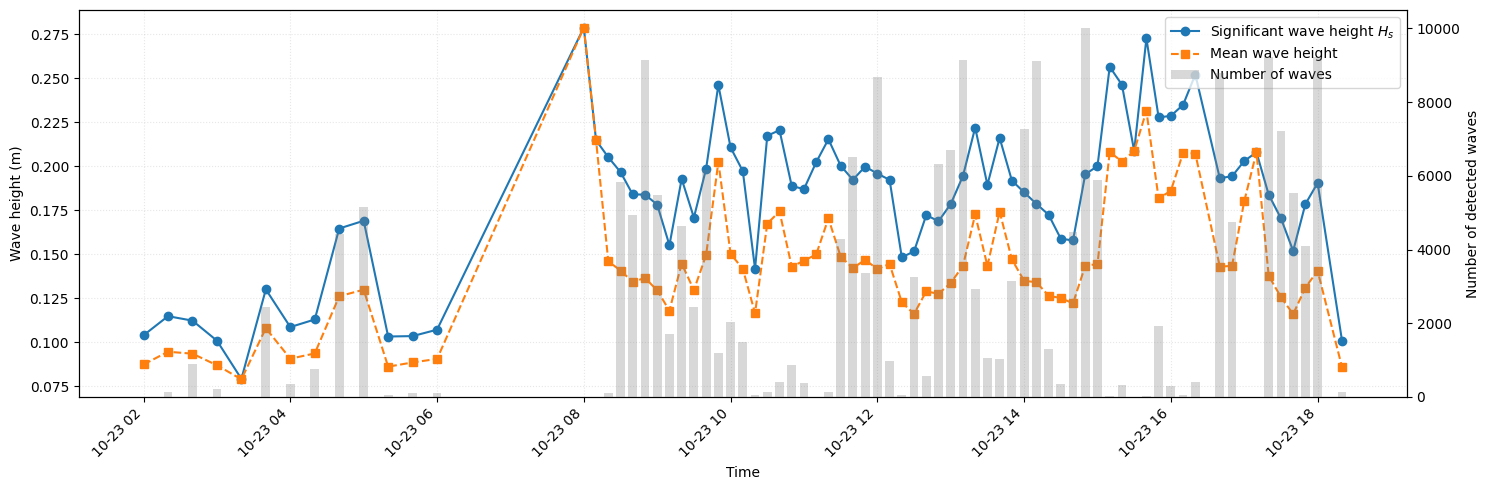

In [49]:
# clean START and END for filenames
start_tag = START.replace(" ", "-").replace(":", "")
end_tag   = END.replace(" ", "-").replace(":", "")

wave_stat_img = f"{start_tag}_{end_tag}_wave_height_statistics_ROI_{model_name}.jpg"
wave_stat_fmg_path = os.path.join(destination_folder_wave, wave_stat_img)

# ------------------------------------------------------------------
# 1. Per-image statistics (including per-image significant wave height)
# ------------------------------------------------------------------

def per_image_stats(group):
    """Return stats for one image group of waves_df."""
    heights = group["height_m"].dropna().values
    n = len(heights)
    if n == 0:
        return pd.Series({
            "number_of_waves": 0,
            "mean_height_m": np.nan,
            "max_height_m": np.nan,
            "Hs_m": np.nan
        })
    heights_sorted = np.sort(heights)[::-1]  # descending
    n_top = max(1, n // 3)                   # top 1/3
    Hs = heights_sorted[:n_top].mean()
    return pd.Series({
        "number_of_waves": n,
        "mean_height_m": heights.mean(),
        "max_height_m": heights.max(),
        "Hs_m": Hs
    })

summary = waves_df.groupby("image").apply(per_image_stats).reset_index()

# ------------------------------------------------------------------
# 2. Extract datetime from image filenames
#    e.g. "img_2025_08_31_06_50_00.png" -> 2025-08-31 06:50:00
# ------------------------------------------------------------------

def parse_time_from_name(name):
    base = os.path.basename(name)               # e.g. img_2025_08_31_06_50_00.png
    stem = os.path.splitext(base)[0]           # img_2025_08_31_06_50_00
    parts = stem.split("_")                    # ['img','2025','08','31','06','50','00']
    # take the last 6 parts: YYYY, MM, DD, HH, MM, SS
    y, m, d, H, M, S = map(int, parts[-6:])
    return pd.to_datetime(f"{y}-{m:02d}-{d:02d} {H:02d}:{M:02d}:{S:02d}")

summary["time"] = summary["image"].apply(parse_time_from_name)

# Sort by time to ensure correct order
summary = summary.sort_values("time").reset_index(drop=True)

print(summary)

# ------------------------------------------------------------------
# 3. Plot: Hs and mean height vs time + wave count on 2nd y-axis
# ------------------------------------------------------------------

fig, ax1 = plt.subplots(figsize=(15, 5))

# Lines for Hs and mean height
ax1.plot(summary["time"], summary["Hs_m"],
         marker="o", linestyle="-", label="Significant wave height $H_s$")
ax1.plot(summary["time"], summary["mean_height_m"],
         marker="s", linestyle="--", label="Mean wave height")

ax1.set_xlabel("Time")
ax1.set_ylabel("Wave height (m)")
ax1.grid(alpha=0.3, linestyle=":")
ax1.legend(loc="upper left")

# Rotate x labels for readability
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

# Secondary axis: number of detected waves as bars
ax2 = ax1.twinx()
ax2.bar(summary["time"], summary["number_of_waves"],
        width=0.005, alpha=0.3, color="gray", label="Number of waves")

ax2.set_ylabel("Number of detected waves")

# Optional: add legend entry for bars
# (need to combine handles from both axes)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.savefig(wave_stat_fmg_path, dpi=300)
plt.tight_layout()
plt.show()